In [1]:
# 1

r=0.03 # 무위험이자율
mp=250000 # 선물거래승수

print('현선물차익거래 예상이익:',6*mp)


현선물차익거래 예상이익: 1500000


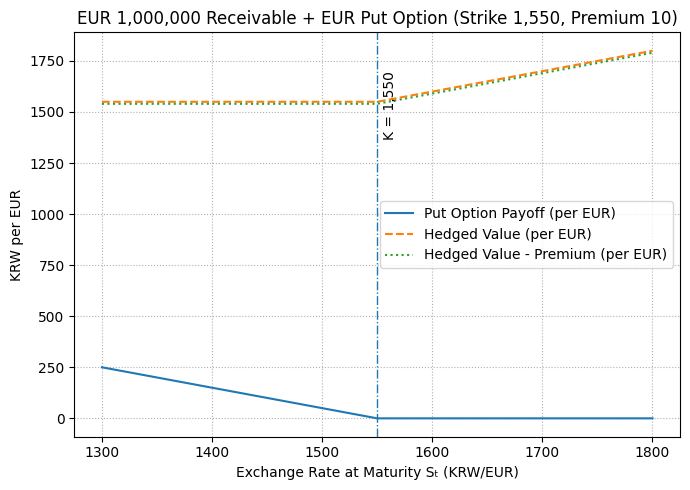

In [2]:
# 2

# Replot the payoff graph with all-English labels
import numpy as np
import matplotlib.pyplot as plt

K = 1550  # strike (KRW/EUR)
premium = 10  # premium (KRW/EUR)
S = np.linspace(1300, 1800, 501)

put_payoff = np.maximum(K - S, 0)
hedged_value = np.maximum(S, K)
hedged_value_net = hedged_value - premium

plt.figure(figsize=(7,5))
plt.plot(S, put_payoff, label='Put Option Payoff (per EUR)')
plt.plot(S, hedged_value, linestyle='--', label='Hedged Value (per EUR)')
plt.plot(S, hedged_value_net, linestyle=':', label='Hedged Value - Premium (per EUR)')
plt.axvline(K, linestyle='-.', linewidth=1)
plt.text(K+5, plt.ylim()[1]*0.9, 'K = 1,550', rotation=90, va='top')

plt.xlabel('Exchange Rate at Maturity Sₜ (KRW/EUR)')
plt.ylabel('KRW per EUR')
plt.title('EUR 1,000,000 Receivable + EUR Put Option (Strike 1,550, Premium 10)')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()

In [3]:
# 5
from sympy import solve, symbols, Eq
from datetime import date

M_yield=0.03 # 시장수익율

# 날짜 설정
start_date = date(2025, 10, 23)
end_date = date(2026, 6, 11)

# 날짜 차이 계산
delta = end_date - start_date

print(f"두 날짜 사이의 일수: {delta.days}일")

T=delta.days/365 # 예금 만기(in years)
Target_nom = 100000000 # T년 후의 목표 원금 보장 수준

N=symbols('N', real=True, positive=True)
equation=Eq(N*(1+M_yield)**(T),Target_nom)
sol=solve(equation,N)
N0=sol[0]
N_mat=N0*(1+M_yield)**(T)
warrant=Target_nom-N0

print(f'{N0} 투자시 만기금액:{N_mat}')
print('----------------------------------------')
print('Total Option Room:',warrant)
print('----------------------------------------')


두 날짜 사이의 일수: 231일
98146681.3771540 투자시 만기금액:99999999.9999997
----------------------------------------
Total Option Room: 1853318.62284602
----------------------------------------


In [4]:
# 6

# Re-run the computation for bond price, duration, and convexity

import math
import pandas as pd

face = 100.0
coupon_rate = 0.035
freq = 2  # semiannual
coupon = face * coupon_rate / freq

yields = {
    1: 0.02303,
    2: 0.02492,
    3: 0.02554,
    5: 0.02677,
    10: 0.02904,
    20: 0.02861,
    30: 0.02767,
    50: 0.02629,
}

def bond_metrics(maturity_years, y_annual):
    m = freq
    n = int(round(maturity_years * m))
    i = y_annual / m  # per-period yield
    # cash flows
    if n == 1:
        cashflows = [coupon + face]
    else:
        cashflows = [coupon] * (n - 1) + [coupon + face]
    # present values
    pvs = []
    times = list(range(1, n + 1))
    for t, cf in zip(times, cashflows):
        df = (1 + i) ** (-t)
        pvs.append(cf * df)
    price = sum(pvs)
    # Macaulay duration (years)
    weighted_time = sum((t / m) * pv for t, pv in zip(times, pvs))
    macaulay = weighted_time / price
    # Modified duration
    modified = macaulay / (1 + i)
    # Convexity (discrete, years^2)
    convex_numerator = sum(cf * (t * (t + 1)) / (1 + i) ** (t + 2) for t, cf in zip(times, cashflows))
    convexity = (convex_numerator / price) / (m ** 2)
    return price, macaulay, modified, convexity

rows = []
for T, y in yields.items():
    price, macaulay, modified, convexity = bond_metrics(T, y)
    rows.append({
        "Maturity (Y)": T,
        "Yield (annual, %)": y * 100,
        "Price (per 100 par)": price,
        "Macaulay Duration (yrs)": macaulay,
        "Modified Duration (yrs)": modified,
        "Convexity (yrs^2)": convexity,
    })

df = pd.DataFrame(rows).sort_values("Maturity (Y)")
# Round for display
df_display = df.copy()
for col in ["Price (per 100 par)", "Macaulay Duration (yrs)", "Modified Duration (yrs)", "Convexity (yrs^2)"]:
    df_display[col] = df_display[col].round(6)

df_display


,Maturity (Y),"Yield (annual, %)",Price (per 100 par),Macaulay Duration (yrs),Modified Duration (yrs),Convexity (yrs^2)
0,1,2.303,101.176638,0.991450,0.980164,1.449330
1,2,2.492,101.954733,1.949556,1.925564,4.713827
2,3,2.554,102.715354,2.875932,2.839669,9.673594
3,5,2.677,103.827603,4.638656,4.577387,24.209364
4,10,2.904,105.140545,8.567473,8.444854,82.737174
5,20,2.861,109.680483,14.831508,14.622335,264.169354
6,30,2.767,114.874747,19.620545,19.352799,492.393312
7,50,2.629,124.154795,26.513322,26.169326,993.738002


In [5]:
# Build a zero curve (semiannual grid) from given YTMs via bootstrapping.
# Assumptions:
# - Coupon bonds: annual coupon 3.5% paid semiannually (1.75 per half-year)
# - Given YTMs are annual nominal with semiannual compounding
# - Zero curve outputs are spot (per annum) with compounding conventions:
#     * For t = 0.5, 1.0, 1.5, ... years: nominal annual with semiannual compounding
#     * For t = 1 day: simple ACT/365 discounting
# - Extra anchors: 1-day zero = 2.25% (simple), 6-month zero = 2.30% (nominal, semiannual)

import math
import pandas as pd

face = 100.0
coupon_rate = 0.035
freq = 2
coupon = face * coupon_rate / freq

# Given par bond YTMs (annual nominal, semiannual compounding)
ytm_points = {
    1.0: 0.02303,
    2.0: 0.02492,
    3.0: 0.02554,
    5.0: 0.02677,
    10.0: 0.02904,
    20.0: 0.02861,
    30.0: 0.02767,
    50.0: 0.02629,
}

# Anchors
r_1d = 0.0225
t_1d = 1/365.0
r_6m = 0.0230  # nominal annual
t_6m = 0.5

# Container for discount factors by time in years
dfs = {}

# 1-day DF (simple)
df_1d = 1 / (1 + r_1d * t_1d)
dfs[round(t_1d, 10)] = df_1d

# 6-month DF (semiannual)
df_6m = 1 / (1 + r_6m / freq)  # one period
dfs[0.5] = df_6m

# Helper to compute price from YTM for a given maturity (years)
def price_from_ytm(maturity_years, y_annual):
    n = int(round(maturity_years * freq))
    i = y_annual / freq
    price = sum(coupon / (1 + i) ** t for t in range(1, n + 1)) + face / (1 + i) ** n
    return price

# Bootstrap semiannual discount factors up to the largest maturity
max_T = int(max(ytm_points.keys()) * freq)
# Build a mapping from N periods to YTM if available
ytm_by_N = {int(T * freq): y for T, y in ytm_points.items()}

# We already know DF for 1 period (0.5y)
# Iterate increasing N; when we reach N with a YTM point, solve DF_N
for N in range(1, max_T + 1):
    T = N / freq
    # DF for N=1 already set from 6m anchor
    if N == 1:
        continue
    if N in ytm_by_N:
        y = ytm_by_N[N]
        price = price_from_ytm(T, y)
        # price = sum_{t=1}^{N-1} c * DF_t + (c + 100) * DF_N
        known_leg = sum(coupon * dfs[t / freq] for t in range(1, N))
        df_N = (price - known_leg) / (coupon + face)
        dfs[T] = df_N
    else:
        # If there's no direct YTM at this N, interpolate in yield space between nearest known YTMs,
        # then treat it as a par bond to bootstrap. (Linear interpolation in maturity-yield space)
        # Find nearest lower and higher YTM anchors
        anchors = sorted(ytm_points.items())
        lower = max((Ti, yi) for Ti, yi in anchors if Ti < T)
        higher = min((Ti, yi) for Ti, yi in anchors if Ti > T)
        # Linear interpolation
        w = (T - lower[0]) / (higher[0] - lower[0])
        y_interp = lower[1] * (1 - w) + higher[1] * w
        price = price_from_ytm(T, y_interp)
        known_leg = sum(coupon * dfs[t / freq] for t in range(1, N))
        df_N = (price - known_leg) / (coupon + face)
        dfs[T] = df_N

# Now compute zero rates from discount factors
# For t on semiannual grid: DF_t = 1 / (1 + z/2)^{2t}  =>  z = 2 * (DF_t^{-1/(2t)} - 1)
zero_curve = []
# Add 1-day as the first point (annualized simple rate)
zero_curve.append({"T (years)": round(t_1d, 6), "Zero Rate (%)": r_1d * 100, "Compounding": "Simple (ACT/365)"})
# Add semiannual grid key maturities (and extract the requested keys later)
for T in sorted(k for k in dfs.keys() if k >= 0.5):
    DF = dfs[T]
    z = 2 * (DF ** (-1 / (2 * T)) - 1)
    zero_curve.append({"T (years)": T, "Zero Rate (%)": z * 100, "Compounding": "Nominal, semiannual"})

zc_df = pd.DataFrame(zero_curve)
zc_df

,T (years),Zero Rate (%),Compounding
0,0.00274,2.250000,Simple (ACT/365)
1,0.50000,2.300000,"Nominal, semiannual"
2,1.00000,2.303026,"Nominal, semiannual"
3,1.50000,2.399170,"Nominal, semiannual"
4,2.00000,2.495739,"Nominal, semiannual"
...,...,...,...
96,48.00000,2.529885,"Nominal, semiannual"
97,48.50000,2.523905,"Nominal, semiannual"
98,49.00000,2.517898,"Nominal, semiannual"
99,49.50000,2.511865,"Nominal, semiannual"


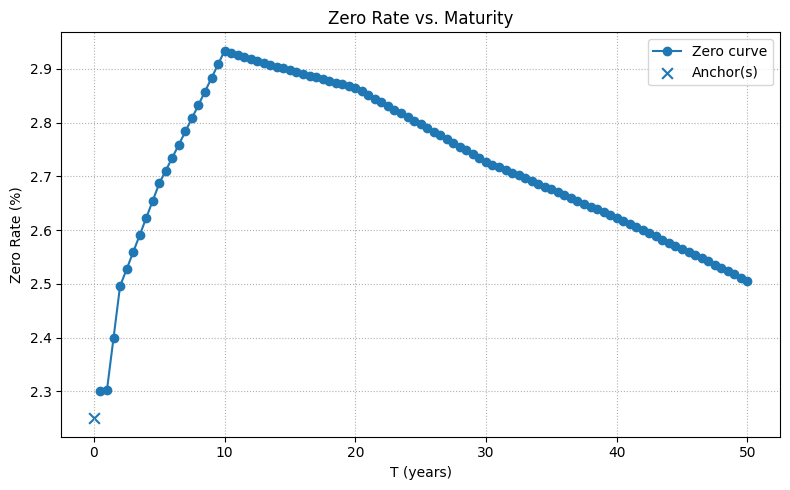

In [6]:
# Plot Zero Rate versus T directly from an existing DataFrame `zc_df`
# This cell assumes you already have a pandas DataFrame named `zc_df`
# with columns: "T (years)", "Zero Rate (%)", "Compounding".

import pandas as pd
import matplotlib.pyplot as plt

# If `zc_df` is not already in memory, uncomment and load from CSV:
# zc_df = pd.read_csv("/mnt/data/zero_curve_full_semiannual_bootstrap.csv")

# Sort by maturity
zc_sorted = zc_df.sort_values("T (years)").copy()

# Split anchor(1-day) and semiannual points for clarity
main = zc_sorted[zc_sorted["Compounding"] == "Nominal, semiannual"]
anchor = zc_sorted[zc_sorted["Compounding"] != "Nominal, semiannual"]

plt.figure(figsize=(8,5))
plt.plot(main["T (years)"], main["Zero Rate (%)"], marker='o', linewidth=1.5, label="Zero curve")
if not anchor.empty:
    plt.scatter(anchor["T (years)"], anchor["Zero Rate (%)"], marker='x', s=60, label="Anchor(s)")

plt.xlabel("T (years)")
plt.ylabel("Zero Rate (%)")
plt.title("Zero Rate vs. Maturity")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()

In [7]:
zc_df.head(10)

,T (years),Zero Rate (%),Compounding
0,0.00274,2.250000,Simple (ACT/365)
1,0.50000,2.300000,"Nominal, semiannual"
2,1.00000,2.303026,"Nominal, semiannual"
3,1.50000,2.399170,"Nominal, semiannual"
4,2.00000,2.495739,"Nominal, semiannual"
5,2.50000,2.527073,"Nominal, semiannual"
6,3.00000,2.558756,"Nominal, semiannual"
7,3.50000,2.590455,"Nominal, semiannual"
8,4.00000,2.622403,"Nominal, semiannual"
9,4.50000,2.654582,"Nominal, semiannual"


In [8]:
# Compute discount factors from a zero curve DataFrame `zc_df`
# Assumptions from the prompt:
# - For "Nominal, semiannual": DF(T) = 1 / (1 + z/2)^(2T) where z is the annual nominal rate
# - For "Simple (ACT/365)": DF(T) = 1 / (1 + z * T) where T is in years

import pandas as pd

def discount_factor(row):
    z = row["Zero Rate (%)"] / 100.0
    T = row["T (years)"]
    comp = row["Compounding"]
    if "Nominal, semiannual" in comp:
        return 1.0 / (1.0 + z/2.0) ** (2.0 * T)
    elif "Simple" in comp:
        return 1.0 / (1.0 + z * T)
    else:
        raise ValueError(f"Unknown compounding: {comp}")

df_out = zc_df.copy()
df_out["Discount Factor"] = df_out.apply(discount_factor, axis=1)
df_out["Discount Factor"] = df_out["Discount Factor"].round(8)
df_out.head(10)

,T (years),Zero Rate (%),Compounding,Discount Factor
0,0.00274,2.250000,Simple (ACT/365),0.999938
1,0.50000,2.300000,"Nominal, semiannual",0.988631
2,1.00000,2.303026,"Nominal, semiannual",0.977362
3,1.50000,2.399170,"Nominal, semiannual",0.964859
4,2.00000,2.495739,"Nominal, semiannual",0.951604
5,2.50000,2.527073,"Nominal, semiannual",0.939149
6,3.00000,2.558756,"Nominal, semiannual",0.926561
7,3.50000,2.590455,"Nominal, semiannual",0.913855
8,4.00000,2.622403,"Nominal, semiannual",0.901032
9,4.50000,2.654582,"Nominal, semiannual",0.888101


In [9]:
# 7

print('FRA 매도와 채권 복제로 인한 예상 수익(백만원):',10**10*(0.4/100)*2/1000000)

FRA 매도와 채권 복제로 인한 예상 수익(백만원): 80.0


[TSLA] 기간: 2023-05-04 ~ 2025-09-26
- 골든 크로스 발생 횟수: 15
  · 처음 5개: [datetime.date(2023, 8, 31), datetime.date(2023, 10, 6), datetime.date(2023, 11, 16), datetime.date(2024, 2, 27), datetime.date(2024, 4, 30)]
  · 최근 5개: [datetime.date(2025, 4, 15), datetime.date(2025, 4, 28), datetime.date(2025, 6, 27), datetime.date(2025, 7, 18), datetime.date(2025, 8, 8)]
- 데드 크로스 발생 횟수: 15
  · 처음 5개: [datetime.date(2023, 7, 26), datetime.date(2023, 9, 27), datetime.date(2023, 10, 17), datetime.date(2024, 1, 5), datetime.date(2024, 3, 6)]
  · 최근 5개: [datetime.date(2025, 4, 4), datetime.date(2025, 4, 16), datetime.date(2025, 6, 9), datetime.date(2025, 6, 30), datetime.date(2025, 7, 30)]

=== 크로스 목록 상위 10개 ===
    CrossDate    Type
0  2023-07-26   Death
1  2023-08-31  Golden
2  2023-09-27   Death
3  2023-10-06  Golden
4  2023-10-17   Death
5  2023-11-16  Golden
6  2024-01-05   Death
7  2024-02-27  Golden
8  2024-03-06   Death
9  2024-04-30  Golden


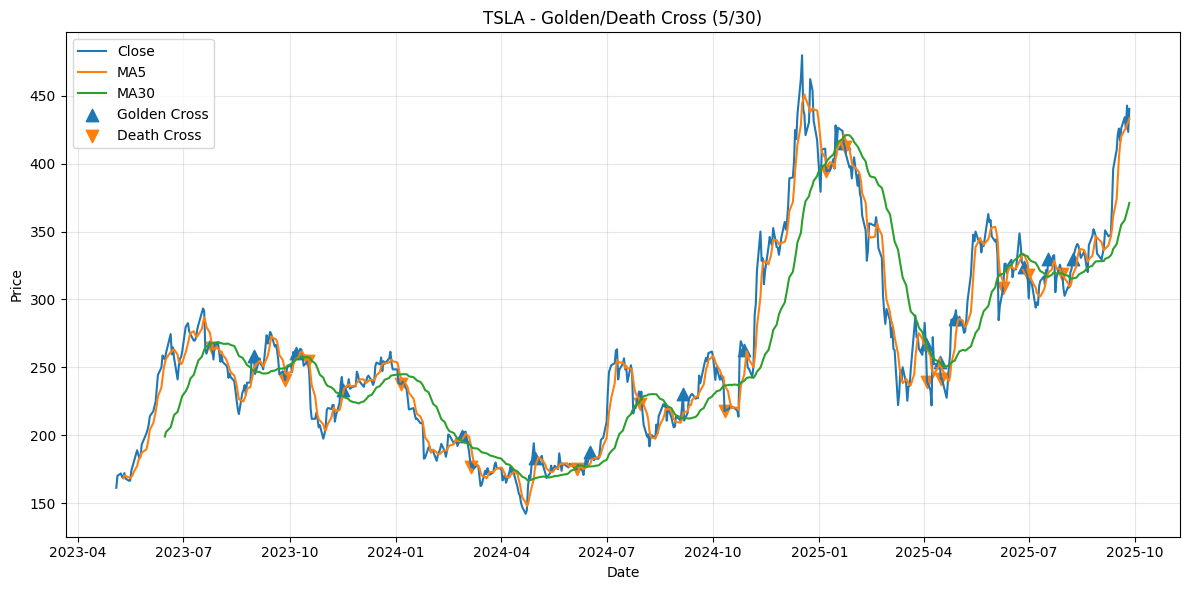

In [10]:
# 8

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt

# --------- 파라미터 ---------
ticker = "TSLA"
start = date(2023, 5, 4)
end = date(2025, 9, 29)
short_win = 5
long_win = 30
# ----------------------------

# 1) 데이터 다운로드 (분할/배당 조정된 종가 사용)
df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
if df.empty:
    raise RuntimeError("데이터를 불러오지 못했습니다. 티커/네트워크/거래일 범위를 확인하세요.")

# 2) 이동평균 계산
df["MA_S"] = df["Close"].rolling(short_win, min_periods=short_win).mean()
df["MA_L"] = df["Close"].rolling(long_win,  min_periods=long_win).mean()

# 3) 크로스 탐지 (직전일과 오늘의 상대 위치 변화로 판정)
prev_s = df["MA_S"].shift(1)
prev_l = df["MA_L"].shift(1)

golden = (df["MA_S"] > df["MA_L"]) & (prev_s <= prev_l)  # 아래→위 돌파
death  = (df["MA_S"] < df["MA_L"]) & (prev_s >= prev_l)  # 위→아래 돌파

golden_dates = df.index[golden].date
death_dates  = df.index[death].date

print(f"[{ticker}] 기간: {df.index.min().date()} ~ {df.index.max().date()}")
print(f"- 골든 크로스 발생 횟수: {len(golden_dates)}")
if len(golden_dates) > 0:
    print("  · 처음 5개:", list(golden_dates[:5]))
    print("  · 최근 5개:", list(golden_dates[-5:]))

print(f"- 데드 크로스 발생 횟수: {len(death_dates)}")
if len(death_dates) > 0:
    print("  · 처음 5개:", list(death_dates[:5]))
    print("  · 최근 5개:", list(death_dates[-5:]))

# 4) 결과 테이블(크로스만) 만들기
cross_df = pd.DataFrame({
    "CrossDate": list(golden_dates) + list(death_dates),
    "Type": (["Golden"]*len(golden_dates)) + (["Death"]*len(death_dates))
}).sort_values("CrossDate").reset_index(drop=True)

print("\n=== 크로스 목록 상위 10개 ===")
print(cross_df.head(10))

# 5) 시각화 (한 장, 종가/MA/골든·데드 마커)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df.index, df["Close"], label="Close")
ax.plot(df.index, df["MA_S"], label=f"MA{short_win}")
ax.plot(df.index, df["MA_L"], label=f"MA{long_win}")

# 마커 찍기
ax.scatter(df.index[golden], df.loc[golden, "Close"], marker="^", s=80, label="Golden Cross")
ax.scatter(df.index[death],  df.loc[death,  "Close"], marker="v", s=80, label="Death Cross")

ax.set_title(f"{ticker} - Golden/Death Cross ({short_win}/{long_win})")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date

# ----------------------------
# 1) 입력: 신호(날짜 리스트)
# ----------------------------
golden_list =golden_dates
dead_list=death_dates

start = "2023-05-04"
end   = "2025-09-26"
ticker = "TSLA"

# ---------------------------------------
# 2) 가격 데이터 다운로드 (Adj Close 사용)
# ---------------------------------------
px = yf.download(ticker, start=start, end=end, auto_adjust=True)[["Close"]].rename(columns={"Close":"AdjClose"})
px.index = pd.to_datetime(px.index)

# ---------------------------------------
# 3) 체결: 신호 '다음 거래일 종가'로
#    - 매수: 골든크로스 다음 거래일 종가
#    - 매도: 데드크로스 다음 거래일 종가
# ---------------------------------------
def next_trading_day_price(dt):
    """신호일 dt(파이썬 date)를 받아, 다음 거래일의 종가를 반환"""
    ts = pd.Timestamp(dt)
    # dt가 거래일이 아닐 수 있으니, 그 다음 영업일(또는 이후 첫 거래일) 종가
    # (dt 이후 첫 번째 인덱스)
    loc = px.index.searchsorted(ts, side="right")
    if loc < len(px.index):
        return px.index[loc], float(px["AdjClose"].iloc[loc])
    return None, np.nan  # 범위를 벗어나면 처리

# (1) 각 골든/데드 신호의 체결일/체결가 추출
gc_exec = []
for d in golden_list:
    dt_exec, px_exec = next_trading_day_price(d)
    if dt_exec is not None:
        gc_exec.append((pd.Timestamp(d), dt_exec, px_exec))  # (signal_day, exec_day, price)

dc_exec = []
for d in dead_list:
    dt_exec, px_exec = next_trading_day_price(d)
    if dt_exec is not None:
        dc_exec.append((pd.Timestamp(d), dt_exec, px_exec))

gc_df = pd.DataFrame(gc_exec, columns=["GC_signal","BuyExec","BuyPx"]).sort_values("BuyExec")
dc_df = pd.DataFrame(dc_exec, columns=["DC_signal","SellExec","SellPx"]).sort_values("SellExec")

# ---------------------------------------
# 4) 골든→데드 순서대로 짝짓기 (교차 페어링)
#    - BuyExec < SellExec 인 첫 데드와 매칭
#    - 마지막에 남은 미청산 롱은 기간 마지막 거래일 종가로 청산
# ---------------------------------------
trades = []
dc_idx = 0
for _, row in gc_df.iterrows():
    buy_exec = row["BuyExec"]
    buy_px   = row["BuyPx"]

    # buy 이후의 첫 번째 데드 체결 찾기
    sell_exec = None
    sell_px   = None
    while dc_idx < len(dc_df) and dc_df.iloc[dc_idx]["SellExec"] <= buy_exec:
        dc_idx += 1
    if dc_idx < len(dc_df):
        sell_exec = dc_df.iloc[dc_idx]["SellExec"]
        sell_px   = dc_df.iloc[dc_idx]["SellPx"]
        dc_idx += 1
    else:
        # 데드 없으면 기간 마지막 날 종가로 청산
        sell_exec = px.index[-1]
        sell_px   = float(px["AdjClose"].iloc[-1])

    tr = {
        "BuyExec": buy_exec, "BuyPx": buy_px,
        "SellExec": sell_exec, "SellPx": sell_px,
        "TradeRet": sell_px / buy_px - 1.0
    }
    trades.append(tr)

trades_df = pd.DataFrame(trades).sort_values("BuyExec")

# ---------------------------------------
# 5) 성과 요약
# ---------------------------------------
cum = (1.0 + trades_df["TradeRet"]).prod() - 1.0
avg = trades_df["TradeRet"].mean() if len(trades_df) else np.nan
win_rate = (trades_df["TradeRet"] > 0).mean() if len(trades_df) else np.nan

print(f"[요약] 총 트레이드 수: {len(trades_df)}")
print(f"누적수익률: {cum:.2%}")
print(f"평균 트레이드 수익률: {avg:.2%}")
print(f"승률: {win_rate:.1%}")

print("\n[앞 5개 트레이드]")
print(trades_df.head(5)[["BuyExec","BuyPx","SellExec","SellPx","TradeRet"]].to_string(index=False))

print("\n[뒤 5개 트레이드]")
print(trades_df.tail(5)[["BuyExec","BuyPx","SellExec","SellPx","TradeRet"]].to_string(index=False))


[*********************100%***********************]  1 of 1 completed

[요약] 총 트레이드 수: 15
누적수익률: 99.20%
평균 트레이드 수익률: 5.78%
승률: 46.7%

[앞 5개 트레이드]
   BuyExec      BuyPx   SellExec     SellPx  TradeRet
2023-09-01 245.009995 2023-09-28 246.380005  0.005592
2023-10-09 259.670013 2023-10-18 242.679993 -0.065429
2023-11-17 234.300003 2024-01-08 240.449997  0.026248
2024-02-28 202.039993 2024-03-07 178.649994 -0.115769
2024-05-01 179.990005 2024-06-06 177.940002 -0.011390

[뒤 5개 트레이드]
   BuyExec      BuyPx   SellExec     SellPx  TradeRet
2025-04-16 241.550003 2025-04-17 241.369995 -0.000745
2025-04-29 292.029999 2025-06-10 326.089996  0.116632
2025-06-30 317.660004 2025-07-01 300.709991 -0.053359
2025-07-21 328.489990 2025-07-31 308.269989 -0.061554
2025-08-11 339.029999 2025-09-25 423.390015  0.248828



/tmp/ipython-input-758120982.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return px.index[loc], float(px["AdjClose"].iloc[loc])
/tmp/ipython-input-758120982.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sell_px   = float(px["AdjClose"].iloc[-1])


In [12]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 21.2 MB/s eta 0:00:00


In [13]:
from pykrx import stock
from pykrx import bond
from datetime import datetime
import pandas as pd

now = datetime.now()
today_date1 = now.strftime('%Y%m%d')
start_date = '20240101'

In [14]:
# krx 종목리스트
market_list = ['KOSPI', 'KOSDAQ', 'KONEX']

kor_ticker_list_df = pd.DataFrame()
for market_nm in market_list:
    ticker_list = stock.get_market_ticker_list(today_date1, market=market_nm)
    for tickers in ticker_list:
        corp_name = stock.get_market_ticker_name(tickers)
        df = pd.DataFrame({'ticker':tickers,
                           'corp_name':corp_name,
                           'market': market_nm
                          }, index = [0])
        kor_ticker_list_df = pd.concat([kor_ticker_list_df,df])
kor_ticker_list_df = kor_ticker_list_df.reset_index(drop = True)
kor_ticker_list_df.head()

,ticker,corp_name,market
0,095570,AJ네트웍스,KOSPI
1,006840,AK홀딩스,KOSPI
2,027410,BGF,KOSPI
3,282330,BGF리테일,KOSPI
4,138930,BNK금융지주,KOSPI


In [15]:
# 9

import numpy as np
# NAVER: 035420
# 농심: 004370
# 카카오뱅크: 323410
# 한화: 000880

tickers=['035420','004370','323410','000880']
# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-09-30', '%Y-%m-%d')

result_df = pd.DataFrame()

for ticker in tickers:
    data = stock.get_market_ohlcv(start_date, end_date, ticker)
    df=pd.DataFrame(data['종가'])

    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'

    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,035420,004370,323410,000880
Date,,,,
2024-01-02,227500,412500,28000,25100
2024-01-03,222000,410500,27200,25000
2024-01-04,223000,408000,26200,24600
2024-01-05,220500,402000,25900,24550
2024-01-08,226500,411000,25950,24300
...,...,...,...,...
2025-09-24,228000,451000,23950,86900
2025-09-25,254000,444000,24150,85800
2025-09-26,256500,437000,23500,83100


<Axes: xlabel='Date'>

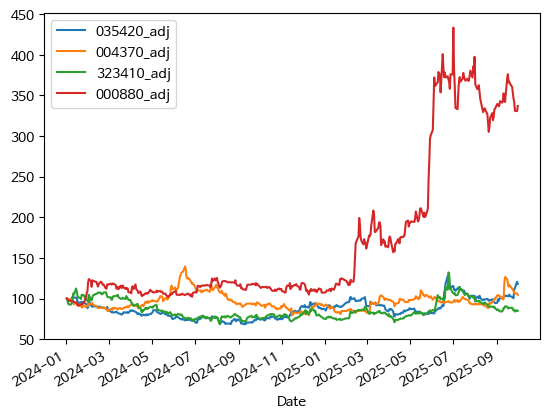

In [16]:
result_df = pd.DataFrame()

for ticker in tickers:

    data = stock.get_market_ohlcv(start_date, end_date, ticker)
    df=pd.DataFrame(data['종가'])

    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'

    # 칼럼 이름 변경
    df.columns = [ticker]

    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df[ticker].iloc[0]
    # 정규화하여 수정주가 칼럼 추가
    df['Adjusted_Close'] = (df[ticker] / ref_price) * 100
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_adj']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


# chart로 그리기
result_df.loc['2024-01':'2025-09',['035420_adj','004370_adj','323410_adj','000880_adj']].plot()

In [17]:
result_df

,035420,035420_adj,004370,004370_adj,323410,323410_adj,000880,000880_adj
Date,,,,,,,,
2024-01-02,227500,100.000000,412500,100.000000,28000,100.000000,25100,100.000000
2024-01-03,222000,97.582418,410500,99.515152,27200,97.142857,25000,99.601594
2024-01-04,223000,98.021978,408000,98.909091,26200,93.571429,24600,98.007968
2024-01-05,220500,96.923077,402000,97.454545,25900,92.500000,24550,97.808765
2024-01-08,226500,99.560440,411000,99.636364,25950,92.678571,24300,96.812749
...,...,...,...,...,...,...,...,...
2025-09-24,228000,100.219780,451000,109.333333,23950,85.535714,86900,346.215139
2025-09-25,254000,111.648352,444000,107.636364,24150,86.250000,85800,341.832669
2025-09-26,256500,112.747253,437000,105.939394,23500,83.928571,83100,331.075697


In [18]:
import pandas as pd


# 035420 종목만 선택
naver = result_df['035420']

# 월별로 리샘플링해서 OHLC 계산
monthly_ohlc = naver.resample('ME').ohlc()
monthly_ohlc

,open,high,low,close
Date,,,,
2024-01-31,227500,231500,200500,200500
2024-02-29,202500,221500,195000,195000
2024-03-31,192000,192000,182600,187400
2024-04-30,194300,194300,179500,184400
2024-05-31,188800,194800,170200,170200
2024-06-30,172700,177100,165400,166900
2024-07-31,162900,178000,159800,174000
2024-08-31,175000,175000,156100,169100
2024-09-30,166600,170900,155000,169400


In [19]:
import numpy as np
# NAVER: 035420
# 농심: 004370
# 카카오뱅크: 323410
# 한화: 000880

tickers=['035420','004370','323410','000880']
# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-09-30', '%Y-%m-%d')

result_df = pd.DataFrame()

for ticker in tickers:
    data = stock.get_market_ohlcv(start_date, end_date, ticker)
    df=pd.DataFrame(data['종가'])

    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'

    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)

# ----------------------------
# 1) Daily log return 계산
# ----------------------------
log_ret = np.log(result_df/ result_df.shift(1))
log_ret = log_ret.dropna()
log_ret.columns = [f"{col}_logret" for col in result_df.columns]

# ----------------------------
# 2) 연간 평균 수익률 & 변동성 계산
# ----------------------------
# 연 252거래일 기준
annual_ret = log_ret.mean() * 252
annual_vol = log_ret.std() * np.sqrt(252)

# ----------------------------
# 3) 결과 요약 테이블 생성
# ----------------------------
summary = pd.DataFrame({
    "Annual Return (%)": annual_ret * 100,
    "Annual Volatility (%)": annual_vol * 100
})

# 열 이름 정리
summary.index = [code.replace("_logret", "") for code in summary.index]
summary

,Annual Return (%),Annual Volatility (%)
035420,9.802012,36.606622
004370,2.663824,38.032684
323410,-9.738202,43.515495
000880,71.877169,54.270727


In [20]:
result_df

,035420,004370,323410,000880
Date,,,,
2024-01-02,227500,412500,28000,25100
2024-01-03,222000,410500,27200,25000
2024-01-04,223000,408000,26200,24600
2024-01-05,220500,402000,25900,24550
2024-01-08,226500,411000,25950,24300
...,...,...,...,...
2025-09-24,228000,451000,23950,86900
2025-09-25,254000,444000,24150,85800
2025-09-26,256500,437000,23500,83100


In [21]:
log_ret

,035420_logret,004370_logret,323410_logret,000880_logret
Date,,,,
2024-01-03,-0.024473,-0.004860,-0.028988,-0.003992
2024-01-04,0.004494,-0.006109,-0.037458,-0.016129
2024-01-05,-0.011274,-0.014815,-0.011516,-0.002035
2024-01-08,0.026847,0.022141,0.001929,-0.010236
2024-01-09,0.013158,-0.020898,0.020973,0.000000
...,...,...,...,...
2025-09-24,-0.013072,-0.009928,-0.010384,-0.021629
2025-09-25,0.107989,-0.015643,0.008316,-0.012739
2025-09-26,0.009794,-0.015891,-0.027284,-0.031974


In [22]:
# 9 (4)
import pandas as pd
import numpy as np


window = 126  # 약 6개월

# 각 시점별 correlation matrix를 DataFrame으로 저장
rolling_corrs = {}

for i in range(window, len(log_ret)):
    date = log_ret.index[i]
    sub = log_ret.iloc[i-window:i]
    corr_matrix = sub.corr()
    rolling_corrs[date] = corr_matrix

# -----------------------------------------
# 2025-09-29 기준 상관행렬 추출
# -----------------------------------------
target_date = pd.Timestamp("2025-09-29")
corr_20250929 = rolling_corrs[target_date]

rolling_corrs


{Timestamp('2024-07-09 00:00:00'):                035420_logret  004370_logret  323410_logret  000880_logret
 035420_logret       1.000000      -0.034846       0.384355       0.151313
 004370_logret      -0.034846       1.000000       0.040438       0.120118
 323410_logret       0.384355       0.040438       1.000000       0.221501
 000880_logret       0.151313       0.120118       0.221501       1.000000,
 Timestamp('2024-07-10 00:00:00'):                035420_logret  004370_logret  323410_logret  000880_logret
 035420_logret       1.000000      -0.037607       0.377600       0.150572
 004370_logret      -0.037607       1.000000       0.038357       0.119513
 323410_logret       0.377600       0.038357       1.000000       0.221091
 000880_logret       0.150572       0.119513       0.221091       1.000000,
 Timestamp('2024-07-11 00:00:00'):                035420_logret  004370_logret  323410_logret  000880_logret
 035420_logret       1.000000      -0.051997       0.369854       0.146

In [23]:
corr_20250929

,035420_logret,004370_logret,323410_logret,000880_logret
035420_logret,1.000000,0.022486,0.399298,0.113465
004370_logret,0.022486,1.000000,0.030354,0.069026
323410_logret,0.399298,0.030354,1.000000,0.143420
000880_logret,0.113465,0.069026,0.143420,1.000000
